In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import psycopg2

%matplotlib inline

# Connect to Basketball DB

In [32]:
try:
    connection = psycopg2.connect(user="postgres",
                                  password="baker1127",
                                  host="localhost",
                                  port="5432",
                                  database="basketball")
    
except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
    
cursor = connection.cursor()    

In [33]:
FEATURE_NUM = 9

cursor.execute("SELECT COUNT(*) FROM gametable")
DATA_POINTS = cursor.fetchall()[0][0]
X = np.zeros(shape=(DATA_POINTS,FEATURE_NUM))

# Query the data needed to train
### The data obtained from the internet is in a format unsuitable for training, so significant data preparation is required first

In [34]:
""" SQL query to fetch needed data """
fetch_query = """WITH tA AS
(SELECT ts1."ID team", ts1.id, ts2.pct, ts3.ppg, ts4.oppg, ts5.spg, ts6.apg, ts7.ftp, ts8.scmg, ts9.rpi, ts10.sos FROM team_statistics ts1 
    JOIN team_statistics ts2 ON ts1."ID team" = ts2."PCT team"
    JOIN team_statistics ts3 ON ts1."ID team" = ts3."PPG team" 
    JOIN team_statistics ts4 ON ts1."ID team" = ts4."OPPG team"
    JOIN team_statistics ts5 ON ts1."ID team" = ts5."SPG team"
    JOIN team_statistics ts6 ON ts1."ID team" = ts6."APG team"
    JOIN team_statistics ts7 ON ts1."ID team" = ts7."FTP team"
    JOIN team_statistics ts8 ON ts1."ID team" = ts8."SCMG team"
    JOIN team_statistics ts9 ON ts1."ID team" = ts9."RPI team"
    JOIN team_statistics ts10 ON ts1."ID team" = ts10."SOS team"),
    
    tB AS
(SELECT ts1."ID team", ts1.id, ts2.pct, ts3.ppg, ts4.oppg, ts5.spg, ts6.apg, ts7.ftp, ts8.scmg, ts9.rpi, ts10.sos FROM team_statistics ts1 
    JOIN team_statistics ts2 ON ts1."ID team" = ts2."PCT team"
    JOIN team_statistics ts3 ON ts1."ID team" = ts3."PPG team" 
    JOIN team_statistics ts4 ON ts1."ID team" = ts4."OPPG team"
    JOIN team_statistics ts5 ON ts1."ID team" = ts5."SPG team"
    JOIN team_statistics ts6 ON ts1."ID team" = ts6."APG team"
    JOIN team_statistics ts7 ON ts1."ID team" = ts7."FTP team"
    JOIN team_statistics ts8 ON ts1."ID team" = ts8."SCMG team"
    JOIN team_statistics ts9 ON ts1."ID team" = ts9."RPI team"
    JOIN team_statistics ts10 ON ts1."ID team" = ts10."SOS team")
    
SELECT tA."ID team", tB."ID team", tA.pct - tB.pct AS "win percentage", 
   tA.rpi - tB.rpi AS "RPI", 
   tA.sos - tB.sos AS "schedule strength", 
   tA.ppg - tB.ppg AS "points per game",
   tA.oppg - tB.oppg AS "opponent points per game",
   tA.scmg - tB.scmg AS "average scoring margin",
   tA.apg - tB.apg AS "assists per game",
   tA.spg - tB.spg AS "steals per game",
   tA.ftp - tB.ftp AS "free throw percentage", gms."score margin" FROM gametable AS gms
   JOIN tA ON gms."team A" = tA.id
   JOIN tB ON gms."team B" = tB.id"""

cursor.execute(fetch_query)

## store data in numpy array and close DB connection 

In [35]:
data = np.array(cursor.fetchall())

X = (data[:,2:FEATURE_NUM+2]).astype(float)
y = (data[:,FEATURE_NUM+2]).astype(float)

cursor.close()
connection.close()

# Train Data with Regression Forest 

## split data into training and test set
#### Note: The sample size is large enough ($\sim \mathcal{O}(\text{10}^3))$ that a simple hold-out method is probably sufficient to test model variance rather than doing a full k-fold cross validation

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## build forest. TODO: hyperparameter optimization to minimize test error

#### Note: leaf sample cutoff should certainly be > 1 to prevent overfit decision trees 

In [38]:
regressor = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, max_features = 'sqrt',random_state=0)

In [39]:
regressor.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=10,
                      n_estimators=200, random_state=0)

# Test Data

In [40]:
y_pred = regressor.predict(X_test)

In [41]:
from sklearn import metrics

rms_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('RMS Error:', rms_error)

RMS Error: 11.08154302505357


## plot test results

correlation coefficient: 0.6856308352006794
bias: 0.1281268441985361


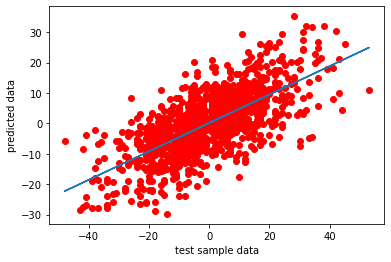

In [42]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(y_test,y_pred)
print("correlation coefficient: {}".format(r_value))
print("bias: {}".format(intercept))
plt.scatter(y_test, y_pred,color='r')
plt.plot(y_test, slope*y_test + intercept)
plt.xlabel("test sample data")
plt.ylabel("predicted data")
plt.show()

In [43]:
test_error = np.average(abs(y_test - y_pred))
print("test error: {}".format(test_error))

test error: 8.58043153001324


## Calculate/plot variable importance

<BarContainer object of 9 artists>

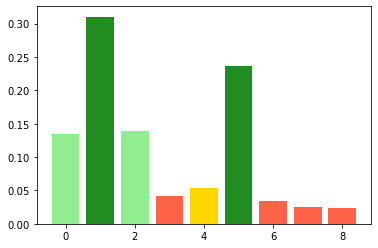

In [44]:
importance = regressor.feature_importances_

clrs = ['tomato' if (x < 0.05) else ('gold' if (x>=0.05 and x<0.1) else ('lightgreen' if (x>=0.1 and x<0.2) else 'forestgreen')) for x in importance]
plt.bar([x for x in range(len(importance))], importance,color=clrs)

# Test a Game: (obtain the predicted scoring margin)

In [61]:
X_test_game = [X[2000,:]]
y_test_game = y[2000]
print(y_test_game)
game_prediction = regressor.predict(X_test_game)
print(game_prediction)

-11.0
[-10.20535649]


## Establish Win Confidence: ($\text{confidence} = \displaystyle \frac{1}{\sqrt{2\pi\sigma^2}}\int_0^\infty e^{(y-\hat{y})^2/2\sigma^2}dy $ where $\hat{y}$ is the predicted scoring margin and $\sigma$ is the model's rms error, calculated above)

### Note that the confidence is defined as the probability of team A winning, which corresponds to positive values of the scoring margin, therefore the integral is taken from 0 to $\infty$. The fundamental assumption in this model is that the possible scoring margins are Gaussian distributed about the predicted margin.

In [62]:
from scipy.stats import norm

mu = game_prediction
sigma = rms_error

win_probability = (1 - norm.cdf(0, loc=mu, scale=sigma))[0]
print("team A win confidence: {}".format(win_probability))

team A win confidence: 0.17854275539229247
